<a href="https://colab.research.google.com/github/map72ru/data_mining/blob/main/hw_webinar_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Я сделал все домашнее задание


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606565 sha256=7ddbfbdf70dd03128584a86cc922a45ba8a66993719ed5450eafcef4f74baa48
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/hw2')

import sys
sys.path.append('/content/hw2/MyDrive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/hw2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [5]:
data = pd.read_csv('/content/hw2/MyDrive/data/retail_train.csv')
item_features = pd.read_csv('/content/hw2/MyDrive/data/product.csv')
user_features = pd.read_csv('/content/hw2/MyDrive/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [7]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [8]:
recommender.get_als_recommendations(2375, N=5)

[844179, 899624, 1044078, 1106523, 8090537]

In [9]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [10]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 933067, 937292, 1003616, 15778319]

In [11]:
recommender.get_similar_users_recommendation(2375, N=5)

[974265, 5568758, 963686, 12523928, 1096573]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [12]:
userid = 2375
k = 50

user_items_id = data_val_lvl_1.query('user_id == @userid').item_id.unique()

recomended_items_id = recommender.get_als_recommendations(userid, N=k)

als_recall = recall_at_k(recomended_items_id, user_items_id, k)
print(f"als={als_recall}")

recomended_items_id = recommender.get_own_recommendations(userid, N=k)
own_recall = recall_at_k(recomended_items_id, user_items_id, k)
print(f"own={own_recall}")

recomended_items_id = recommender.get_similar_items_recommendation(userid, N=k)
sitems_recall = recall_at_k(recomended_items_id, user_items_id, k)
print(f"similar_items={sitems_recall}")

recomended_items_id = recommender.get_similar_users_recommendation(userid, N=k)
susers_recall = recall_at_k(recomended_items_id, user_items_id, k)
print(f"similar_users={susers_recall}")

als=0.07352941176470588
own=0.08823529411764706
similar_items=0.029411764705882353
similar_users=0.0


own+top popular дают лучший результат

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [13]:
# Есть пользователи, для которых нет данных в трейне
user_ids=data_train_lvl_1.user_id.unique()
not_data_users = data_val_lvl_1.query('user_id not in @user_ids')['user_id'].unique()

In [14]:
data_val_lvl_1 = data_val_lvl_1.query('user_id not in @not_data_users')

In [15]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
for m in [20, 50, 100, 200, 500, 1000]:
    recomended_items_id = recommender.get_own_recommendations(userid, N=m)
    own_recall = 100*recall_at_k(recomended_items_id, user_items_id, m)
    print(f"k = {m} own={own_recall}")

k = 20 own=1.4705882352941175
k = 50 own=8.823529411764707
k = 100 own=13.23529411764706
k = 200 own=17.647058823529413
k = 500 own=27.941176470588236
k = 1000 own=27.941176470588236



Чем больше k, тем метрика будет больше, поскольку вероятность попадания рекоментованных в купленные товары будет возростать. Если разумность значения k рассматривать чисто с математической точки зрения, то при достаточно большом K мы будем увеличивать метрику до 1. Если "разумность" рассмтаривать с точки зрения взаимодействия с пользователем, то самым разумным будет 20 из предложенного списка, хотя recall равен 0. Видно так же, что после 200 прирост точности замедляется. Я делал расчте для 1000. recall@1000 был равен 27.941176470588236


In [17]:
result_lvl_1['prediction'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5))

In [18]:
# Посчитаем precision@5 для модели первого уровня
prec5=result_lvl_1.apply(lambda x: precision_at_k(x['prediction'], x['actual']), axis=1)
prec5model1 = prec5.mean()
prec5model1

0.17712691771268974

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [19]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [20]:
for col in user_features.columns:
  if col != 'user_id':
    print(f'column {col}: {user_features[col].unique()}')


column age_desc: ['65+' '45-54' '25-34' '35-44' '19-24' '55-64']
column marital_status_code: ['A' 'U' 'B']
column income_desc: ['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K']
column homeowner_desc: ['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner']
column hh_comp_desc: ['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids']
column household_size_desc: ['2' '3' '4' '1' '5+']
column kid_category_desc: ['None/Unknown' '1' '2' '3+']


In [21]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [22]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [23]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [24]:
def add_user_features(data_set, user_features):

  cols = data_set[['user_id', 'quantity', 'sales_value', 'day']]
  newdf = cols.copy()
  # количество покупок и сумма всех покупок
  newdf1 = newdf.groupby('user_id').agg({'quantity': 'count', 'sales_value': 'sum'})
  # Средний чек
  newdf1['check']=newdf1['sales_value']/newdf1['quantity']

  newdf2 = newdf.groupby('user_id').agg({'day': 'count', 'quantity': 'sum'})
  # среднее количество покупок за раз
  newdf2['avg_qnt_day'] = newdf2['quantity']/newdf2['day']
  # частота покупок
  newdf2['frq'] = newdf2['day']/len(data_train_lvl_1.day.unique())

  newdf = newdf2.merge(newdf1, how='left', on='user_id')
  cols = newdf[['avg_qnt_day', 'frq', 'sales_value', 'check']]
  newdf = cols.copy()

  if len(user_features.columns.intersection(newdf.columns)) > 0:
    for user_id, row in newdf.iterrows():
      user_features.loc[user_features['user_id'] == user_id, 'frq'] = row['frq']
      user_features.loc[user_features['user_id'] == user_id, 'user_sales_value'] = row['sales_value']
      user_features.loc[user_features['user_id'] == user_id, 'check'] = row['check']
      user_features.loc[user_features['user_id'] == user_id, 'chavg_qnt_dayeck'] = row['avg_qnt_day']
    return user_features

  return user_features.merge(newdf, how='left', on='user_id')

In [25]:
user_features_ext = add_user_features(data_train_lvl_2, user_features)
user_features_ext = add_user_features(data_val_lvl_2, user_features_ext)

user_features_ext.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,avg_qnt_day,frq,sales_value,check,user_sales_value,chavg_qnt_dayeck
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,1.112782,0.138280,341.78,2.440488,200.12,1.134146
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,1.288889,0.220911,187.65,2.653130,347.56,1.259542


In [26]:
for col in item_features.columns:
  if col != 'item_id':
    print(f'column {col}: {item_features[col].unique()}')

column manufacturer: [   2   69   16 ... 2748 4868 2227]
column department: ['GROCERY' 'MISC. TRANS.' 'PASTRY' 'DRUG GM' 'MEAT-PCKGD' 'SEAFOOD-PCKGD'
 'PRODUCE' 'NUTRITION' 'DELI' 'COSMETICS' 'MEAT' 'FLORAL'
 'TRAVEL & LEISUR' 'SEAFOOD' 'MISC SALES TRAN' 'SALAD BAR' 'KIOSK-GAS'
 'ELECT &PLUMBING' 'GRO BAKERY' 'GM MERCH EXP' 'FROZEN GROCERY'
 'COUP/STR & MFG' 'SPIRITS' 'GARDEN CENTER' 'TOYS' 'CHARITABLE CONT'
 'RESTAURANT' 'RX' 'PROD-WHS SALES' 'MEAT-WHSE' 'DAIRY DELI' 'CHEF SHOPPE'
 'HBC' 'DELI/SNACK BAR' 'PORK' 'AUTOMOTIVE' 'VIDEO RENTAL' ' '
 'CNTRL/STORE SUP' 'HOUSEWARES' 'POSTAL CENTER' 'PHOTO' 'VIDEO'
 'PHARMACY SUPPLY']
column brand: ['National' 'Private']
column commodity_desc: ['FRZN ICE' 'NO COMMODITY DESCRIPTION' 'BREAD' 'FRUIT - SHELF STABLE'
 'COOKIES/CONES' 'SPICES & EXTRACTS' 'VITAMINS' 'BREAKFAST SWEETS'
 'PNT BTR/JELLY/JAMS' 'ICE CREAM/MILK/SHERBTS' 'MAGAZINE' 'AIR CARE'
 'CHEESE' 'SHORTENING/OIL' 'COFFEE' 'DIETARY AID PRODUCTS'
 'PAPER HOUSEWARES' 'BAKED BREAD/BUNS/ROL

In [27]:
def add_items_features(data_set, item_features):
  cols = data_set[['item_id', 'quantity', 'sales_value', 'week_no']]
  newdf = cols.copy()

# Сколько всего продали такого товара и на какую сумму
  newdf1 = newdf.groupby('item_id').agg({'quantity': 'sum', 'sales_value': 'sum'})
  newdf2 = newdf.groupby('item_id').agg({'week_no': 'count', 'quantity':'sum'})
# Среднее количество товаров, продаваемое в неделю
  newdf2['avg_qnt_week'] = newdf2['week_no']/newdf2['quantity']
  newdf2.drop(['quantity', 'week_no'], axis=1, inplace=True);
  newdf2 = newdf1.merge(newdf2, how='left', on='item_id')

  if len(item_features.columns.intersection(newdf2.columns)) > 0:
    for item_id, row in newdf2.iterrows():
        item_features.loc[item_features['item_id'] == item_id, 'item_quantity'] = row['quantity']
        item_features.loc[item_features['item_id'] == item_id, 'item_sales_value'] = row['sales_value']
        item_features.loc[item_features['item_id'] == item_id, 'avg_qnt_week'] = row['avg_qnt_week']
    return item_features

  return item_features.merge(newdf2, how='left', on='item_id')


In [53]:
item_features_ext = add_items_features(data_train_lvl_2, item_features)
item_features_ext = add_items_features(data_val_lvl_2, item_features_ext)

item_features_ext.query('item_id in @data_val_lvl_2.item_id').head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity,sales_value,avg_qnt_week,item_quantity,item_sales_value
107,29512,69,GROCERY,Private,CANNED JUICES,TOMATO JUICE (OVER 50% JCE),46 OZ,NaN,NaN,1.0,1.0,0.99
131,30356,69,DRUG GM,Private,KITCHEN GADGETS,GADGETS/TOOLS,,NaN,NaN,1.0,1.0,2.39


In [29]:
# Расчет фичей покупатель/товар
# Кол-во покупок юзером конкретной категории в неделю. Категория MEAT
# 
feat1 = data_train_lvl_2.merge(item_features, how="inner", on="item_id")[['item_id', 'user_id', 'quantity', 'department', 'week_no']]
meat_only=feat1.query('department == "MEAT"')
feat1 = meat_only.groupby(['item_id', 'user_id', 'week_no']).agg({'quantity': 'sum'})
feat2 = meat_only.groupby(['item_id']).agg({'week_no': 'count', 'quantity': 'sum'})
feat1.rename(columns = {'quantity': 'avg_meat'}, inplace=True)
# Среднее кол-во покупок всеми юзерами конкретной категории в неделю. Категория MEAT
feat2['avg_cnt'] = feat2['quantity']/feat2['week_no']

train_lvl_2 = data_train_lvl_2.merge(feat1, how="left", on=['item_id','user_id','week_no'])
for index, row in feat2.iterrows():
# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю). Категория MEAT
  train_lvl_2['avg_meat_by_week'] = train_lvl_2.loc[train_lvl_2['item_id'] == index, 'avg_meat']/row['avg_cnt']
  train_lvl_2.loc[train_lvl_2['item_id'] == index, 'avg_cnt'] = row['avg_cnt']

feat1 = data_val_lvl_2.merge(item_features, how="inner", on="item_id")[['item_id', 'user_id', 'quantity', 'department', 'week_no']]
meat_only=feat1.query('department == "MEAT"')
feat1 = meat_only.groupby(['item_id', 'user_id', 'week_no']).agg({'quantity': 'sum'})
feat2 = meat_only.groupby(['item_id']).agg({'week_no': 'count', 'quantity': 'sum'})
feat1.rename(columns = {'quantity': 'avg_meat'}, inplace=True)
# Среднее кол-во покупок всеми юзерами конкретной категории в неделю. Категория MEAT
feat2['avg_cnt'] = feat2['quantity']/feat2['week_no']

val_lvl_2 = data_val_lvl_2.merge(feat1, how="left", on=['item_id','user_id','week_no'])
for index, row in feat2.iterrows():
# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю). Категория MEAT
  val_lvl_2.loc[val_lvl_2['item_id'] == index, 'avg_meat_by_week'] = val_lvl_2.loc[val_lvl_2['item_id'] == index, 'avg_meat']/row['avg_cnt']
  val_lvl_2.loc[val_lvl_2['item_id'] == index, 'avg_cnt'] = row['avg_cnt']


In [30]:
val_lvl_2.query('item_id==17104265')

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avg_meat,avg_meat_by_week,avg_cnt
55331,132,41466761472,650,17104265,1,2.63,363,0.0,1516,94,0.0,0.0,1.0,1.0,1.0


In [31]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [32]:
targets_lvl_2 = train_lvl_2[['user_id', 'item_id', 'avg_meat', 'avg_meat_by_week', 'avg_cnt']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [33]:
targets_lvl_2.head(2)

,user_id,item_id,avg_meat,avg_meat_by_week,avg_cnt,target
0,2070,1105426,NaN,NaN,NaN,0.0
1,2070,1097350,NaN,NaN,NaN,0.0


In [34]:
targets_lvl_2 = targets_lvl_2.merge(item_features_ext, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_ext, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,avg_meat,avg_meat_by_week,avg_cnt,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity,sales_value_x,avg_qnt_week,item_quantity,item_sales_value,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_qnt_day,frq,sales_value_y,check,user_sales_value,chavg_qnt_dayeck
0,2070,1105426,NaN,NaN,NaN,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,5.0,19.95,0.8,5.0,17.96,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,86.029412,0.706577,617.29,2.928401,1227.0,26.00716
1,2070,1097350,NaN,NaN,NaN,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1.0,10.99,1.0,NaN,NaN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,86.029412,0.706577,617.29,2.928401,1227.0,26.00716


In [35]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111313 entries, 0 to 111312
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               111313 non-null  int64  
 1   item_id               111313 non-null  int64  
 2   avg_meat              503 non-null     float64
 3   avg_meat_by_week      0 non-null       float64
 4   avg_cnt               503 non-null     float64
 5   target                111313 non-null  float64
 6   manufacturer          111313 non-null  int64  
 7   department            111313 non-null  object 
 8   brand                 111313 non-null  object 
 9   commodity_desc        111313 non-null  object 
 10  sub_commodity_desc    111313 non-null  object 
 11  curr_size_of_product  111313 non-null  object 
 12  quantity              103073 non-null  float64
 13  sales_value_x         103073 non-null  float64
 14  avg_qnt_week          104617 non-null  float64
 15  

In [36]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [37]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['avg_meat',
 'avg_meat_by_week',
 'avg_cnt',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'quantity',
 'sales_value_x',
 'avg_qnt_week',
 'item_quantity',
 'item_sales_value',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'avg_qnt_day',
 'frq',
 'sales_value_y',
 'check',
 'user_sales_value',
 'chavg_qnt_dayeck']

In [38]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


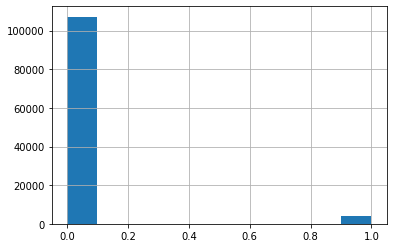

In [40]:
pd.Series(train_preds).hist()

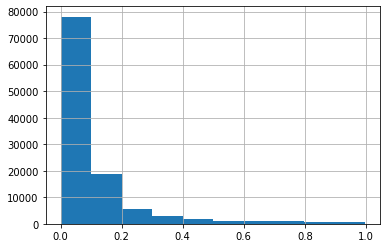

In [42]:
train_proba = lgb.predict_proba(X_train)[:,1]
pd.Series(train_proba).hist()

Что-то есть даже с 1

In [60]:
add_featues_lvl_2 = val_lvl_2[['user_id', 'item_id', 'avg_meat', 'avg_meat_by_week', 'avg_cnt']].copy()

In [54]:
users_lvl_2_val = pd.DataFrame(val_lvl_2['user_id'].unique())
users_lvl_2_val.columns = ['user_id']

# Пока только warm start
train_users = train_lvl_1['user_id'].unique()
users_lvl_2_val = users_lvl_2_val[users_lvl_2_val['user_id'].isin(train_users)]

users_lvl_2_val['candidates'] = users_lvl_2_val['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [55]:
s = users_lvl_2_val.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2_val = users_lvl_2_val.drop('candidates', axis=1).join(s)

users_lvl_2_val.head(4)

,user_id,item_id
0,338,6979393
0,338,13002975
0,338,938165
0,338,823031


In [62]:
users_lvl_2_val_ext = users_lvl_2_val.merge(add_featues_lvl_2, how="left", on=['user_id', "item_id"])
users_lvl_2_val_ext.head(2)

,user_id,item_id,avg_meat,avg_meat_by_week,avg_cnt
0,338,6979393,2.0,1.230769,1.625
1,338,6979393,3.0,1.846154,1.625


In [63]:
pred_2 = users_lvl_2_val_ext.merge(user_features_ext, how="left", on="user_id")
pred_2 = pred_2.merge(item_features_ext, how="left", on="item_id")

pred_2.head(2)

,user_id,item_id,avg_meat,avg_meat_by_week,avg_cnt,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_qnt_day,frq,sales_value_x,check,user_sales_value,chavg_qnt_dayeck,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity,sales_value_y,avg_qnt_week,item_quantity,item_sales_value
0,338,6979393,2.0,1.230769,1.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2844,MEAT,National,BEEF,FLANK,,13.0,32.67,0.615385,13.0,30.17
1,338,6979393,3.0,1.846154,1.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2844,MEAT,National,BEEF,FLANK,,13.0,32.67,0.615385,13.0,30.17


In [66]:
X_val = pred_2
cat_feats = X_val.columns[2:].tolist()
X_val[cat_feats] = X_val[cat_feats].astype('category')

In [67]:
val_pres = lgb.predict(X_val)

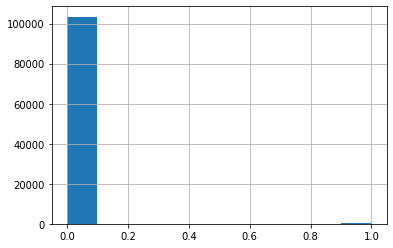

In [69]:
pd.Series(val_pres).hist()

In [73]:
val_proba = lgb.predict_proba(X_val)[:,1]

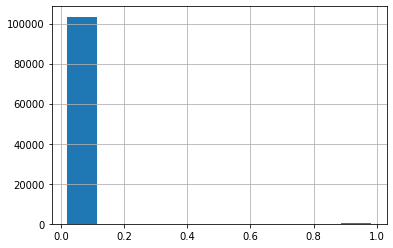

In [74]:
pd.Series(val_proba).hist()

In [75]:
pred_2['proba'] = val_proba

In [77]:
recomendations = pred_2[["user_id", "item_id", "proba"]]
recomendations

,user_id,item_id,proba
0,338,6979393,0.839189
1,338,6979393,0.416952
2,338,13002975,0.942416
3,338,13002975,0.942416
4,338,938165,0.056325
...,...,...,...
103716,832,1127831,0.056325
103717,832,866211,0.056325
103718,832,8090521,0.056325
103719,832,878996,0.056325


In [84]:
lgbm_val = pd.DataFrame(recomendations.sort_values(['user_id', 'proba'], ascending=False).groupby('user_id').apply(lambda x: x['item_id'].iloc[:5].values)).rename(columns={0:'lgbm'})
lgbm_val

,lgbm
user_id,
1,"[856942, 856942, 9297615, 5577022, 877391]"
3,"[1092937, 1008714, 12132312, 1075979, 998206]"
6,"[6979393, 13003092, 972416, 995598, 923600]"
7,"[998519, 894360, 7147142, 9338009, 896666]"
8,"[12808385, 981660, 939860, 7410201, 6463874]"
...,...
2496,"[872826, 983665, 991546, 1134296, 7441210]"
2497,"[870515, 1117219, 1102207, 1057168, 1135834]"
2498,"[1022066, 1076580, 1100379, 5565356, 931579]"


In [90]:
val_actual = pd.DataFrame(data_val_lvl_2.groupby('user_id')['item_id'].unique()).rename(columns={'item_id': 'actual'}).reset_index()
val_actual

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...
2037,2496,[6534178]
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813..."


In [91]:
total_val = lgbm_val.merge(val_actual, how='left', on='user_id')
total_val

,user_id,lgbm,actual
0,1,"[856942, 856942, 9297615, 5577022, 877391]","[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[1092937, 1008714, 12132312, 1075979, 998206]","[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[6979393, 13003092, 972416, 995598, 923600]","[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[998519, 894360, 7147142, 9338009, 896666]","[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[12808385, 981660, 939860, 7410201, 6463874]","[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...,...
2035,2496,"[872826, 983665, 991546, 1134296, 7441210]",[6534178]
2036,2497,"[870515, 1117219, 1102207, 1057168, 1135834]","[1016709, 9835695, 1132298, 16809501, 845294, ..."
2037,2498,"[1022066, 1076580, 1100379, 5565356, 931579]","[15716530, 834484, 901776, 914190, 958382, 972..."
2038,2499,"[7168055, 1128395, 6904613, 5570048, 889989]","[867188, 877580, 902396, 914190, 951590, 95813..."


In [96]:
total_val.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis=1).mean()*100

14.813725490195932

In [97]:
prec5model1*100

17.71269177126897

Как-то не выросло, а на оборот даже ... Видно фичи, которые были добавлены либо не правильно рассчитаны, либо не дают нужной прибавки к информации.